In [59]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

## Данные

In [42]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
passengers.columns = ["y"]

In [43]:
passengers.head()

,y
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


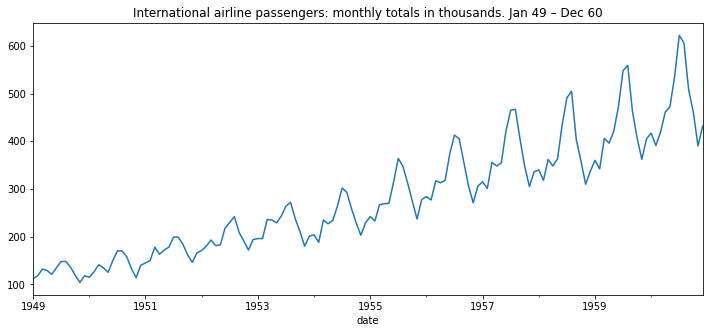

In [56]:
passengers["y"].plot(figsize=(12,5))
plt.title("International airline passengers: monthly totals in thousands. Jan 49 – Dec 60")
plt.show()

In [46]:
s = 12

passlen = len(passengers)
phi = [np.sin((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
psi = [np.cos((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
x1 = list(range(1, len(passengers) + 1))

# passengers["const"] = 1
passengers["x1"] = x1
passengers["phi"] = phi
passengers["psi"] = psi

In [47]:
passengers.head()

,y,x1,phi,psi
date,,,,
1949-01-01,112,1,0.000000,1.000000e+00
1949-02-01,118,2,0.500000,8.660254e-01
1949-03-01,132,3,0.866025,5.000000e-01
1949-04-01,129,4,1.000000,6.123234e-17
1949-05-01,121,5,0.866025,-5.000000e-01


## Подбор параметров

In [48]:
def mse(data, theta0, theta1, beta1, beta2):
    return np.mean((data["y"] - (theta0 + theta1*data["x1"] + beta1*data["phi"] + beta2*data["psi"]))**2)

In [51]:
opfunc = lambda x: mse(passengers, x[0], x[1], x[2], x[3])

optimization = minimize(opfunc, (0, 0, 0, 0))

print(optimization)
theta0, theta1, beta1, beta2 = optimization.x

      fun: 1042.0664148569094
 hess_inv: array([[ 2.16199880e+00, -2.26887084e-02,  1.13830718e-01,
         5.84308704e-03],
       [-2.26887084e-02,  3.09821489e-04, -9.88384656e-04,
         3.76018230e-05],
       [ 1.13830718e-01, -9.88384656e-04,  9.68934013e-01,
         8.17598521e-02],
       [ 5.84308704e-03,  3.76018230e-05,  8.17598521e-02,
         1.00643150e+00]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 105
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([ 88.18246327,   2.64987789,   5.42625932, -45.49952248])


In [66]:
print(f"MSE: {optimization.fun}")

MSE: 1042.0664148569094


In [54]:
approx = theta0 + theta1*passengers["x1"] + beta1*passengers["phi"] + beta2*passengers["psi"]

## Аппроксимация

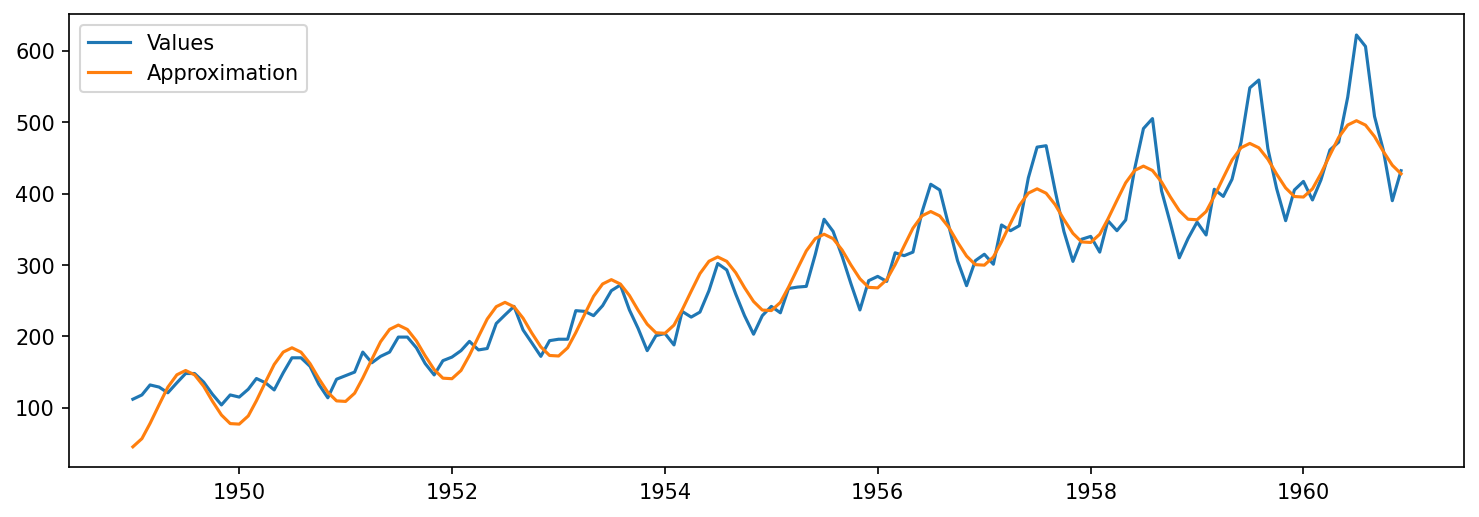

In [57]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

## Прогноз

In [60]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [62]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [64]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

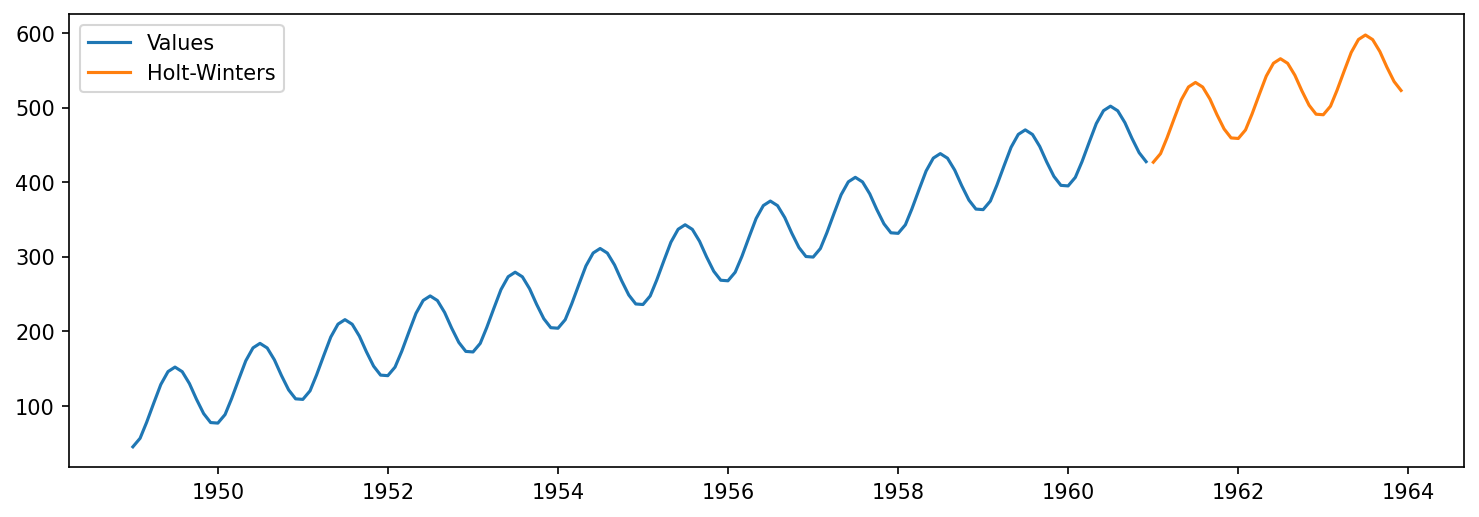

In [65]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

## Анализ остатков

In [67]:
res = passengers["y"] - approx

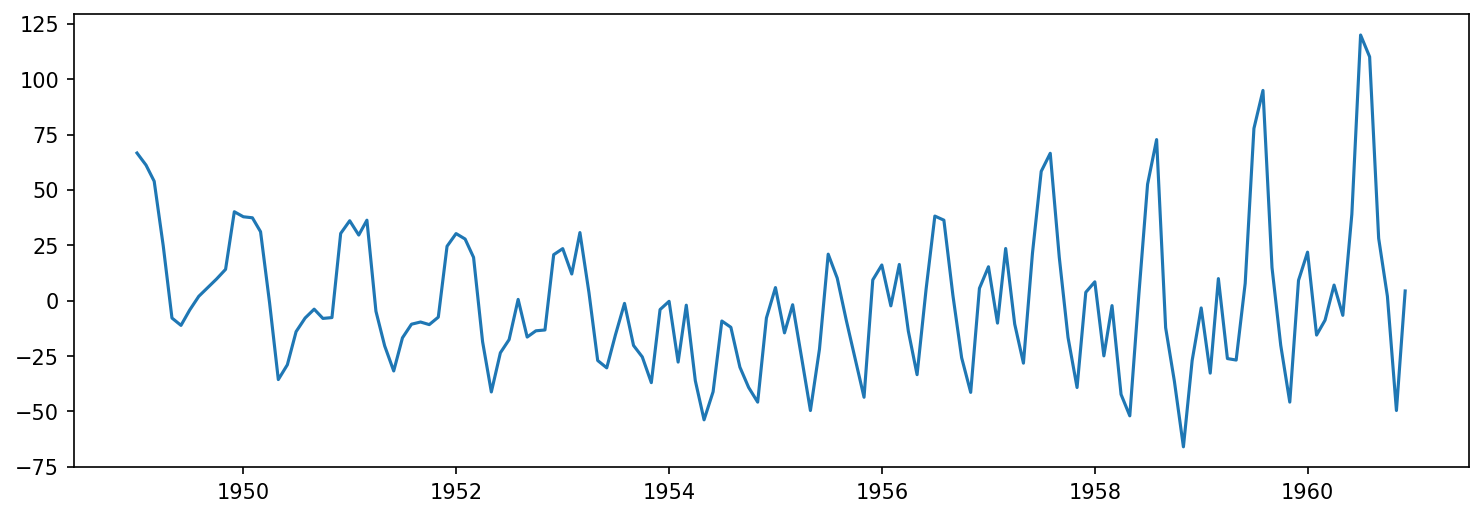

In [68]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(res)
plt.show()

## Новые критерии

In [118]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [116]:
df = pd.get_dummies(passengers.index.month).set_index(passengers.index)

In [120]:
df["y"] = passengers["num_passengers"]

In [122]:
df.columns = [f"x{i}"for i in range(1, 13)] + ["y"]

In [123]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
date,,,,,,,,,,,,,
1949-01-01,1,0,0,0,0,0,0,0,0,0,0,0,112
1949-02-01,0,1,0,0,0,0,0,0,0,0,0,0,118
1949-03-01,0,0,1,0,0,0,0,0,0,0,0,0,132
1949-04-01,0,0,0,1,0,0,0,0,0,0,0,0,129
1949-05-01,0,0,0,0,1,0,0,0,0,0,0,0,121


In [148]:
def mse(data, var):
    return np.mean((data["y"] - (var[0] + sum([var[i-1]*data[f"x{i}"] for i in range(1, 13)])))**2)

In [149]:
opfunc = lambda x: mse(df, x)

optimization = minimize(opfunc, [0 for i in range(12)])

print(optimization)
var = optimization.x

      fun: 12775.429976937381
 hess_inv: array([[ 1.08339968, -0.63277487, -0.86020374, -0.86853054, -0.90179338,
        -1.15487223, -1.43292363, -1.40588956, -1.07130775, -0.87259509,
        -0.61419255, -0.83948624],
       [-0.63277487,  2.28717528,  0.85564708,  0.98531953,  0.84468584,
         0.35440512, -0.04251085, -0.13051915,  0.46057604,  0.9105101 ,
         1.39561599,  1.05130925],
       [-0.86020374,  0.85564708,  1.97442745,  1.01901718,  1.01537007,
         1.14473278,  1.32594493,  1.27337842,  1.08624685,  1.0030849 ,
         0.86566902,  1.00691011],
       [-0.86853054,  0.98531953,  1.01901718,  2.0733166 ,  1.0485821 ,
         1.08259608,  1.17174974,  1.11680291,  1.05216523,  1.04784342,
         1.0107436 ,  1.07276333],
       [-0.90179338,  0.84468584,  1.01537007,  1.0485821 ,  2.06317785,
         1.25071036,  1.48264921,  1.43697765,  1.17517185,  1.04383535,
         0.83994664,  1.02941595],
       [-1.15487223,  0.35440512,  1.14473278,  1.0825

In [151]:
approx = var[0] + sum([var[i-1]*df[f"x{i}"] for i in range(1, 13)])

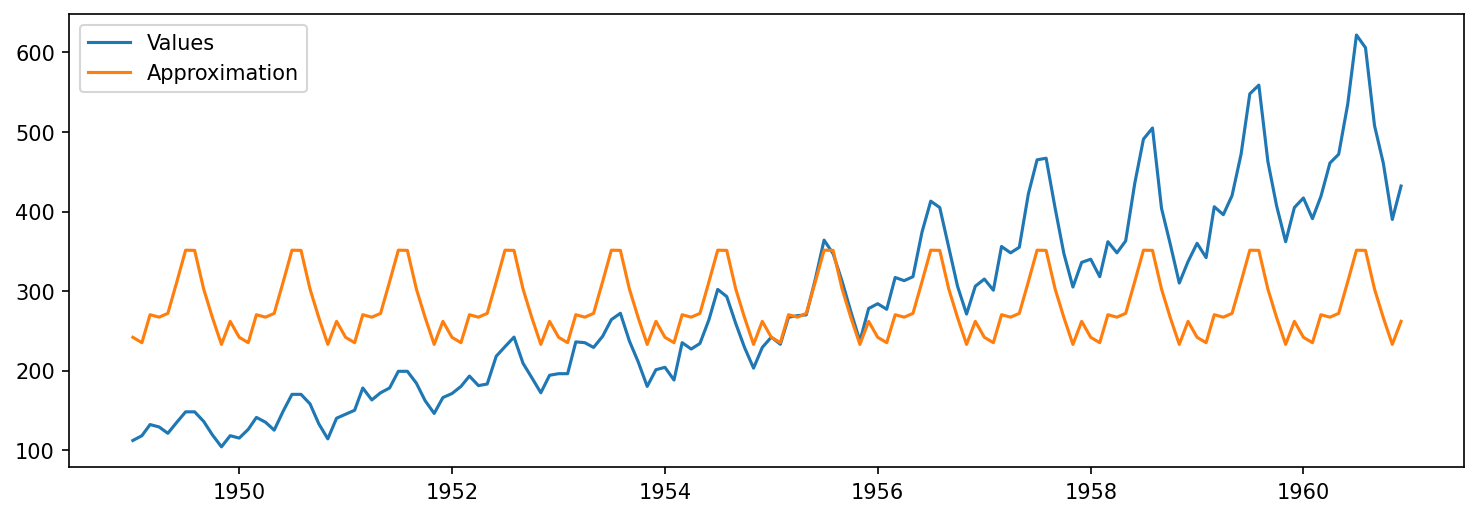

In [152]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()